In [1]:
import scanpy as sc 

In [2]:
adata= sc.read_h5ad('/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_scvi_runs/processed_adata/adata_nlatent15_nlayers2_nhidden128_nhvg10000.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 1566871 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'Sample_ID', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score', 'predicted_doublets', 'scrublet_cluster_score', 'bh_pval', 'predicted_doublets_

In [6]:
# debug:
print("→ uns keys:", list(adata.uns.keys()), flush=True)
print("→ obsp keys:", list(adata.obsp.keys()), flush=True)

→ uns keys: ['Technology_colors', 'X_scVI', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'majority_voting_Level1_colors', 'umap']
→ obsp keys: ['X_scVI_connectivities', 'X_scVI_distances']


In [7]:
adata.uns['X_scVI']

{'connectivities_key': 'X_scVI_connectivities',
 'distances_key': 'X_scVI_distances',
 'params': {'method': 'umap',
  'metric': 'euclidean',
  'n_neighbors': 15,
  'random_state': 0,
  'use_rep': 'X_scVI'}}

In [4]:
adata2= sc.read_h5ad('/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_filtered_with_metadata_scvi.h5ad')

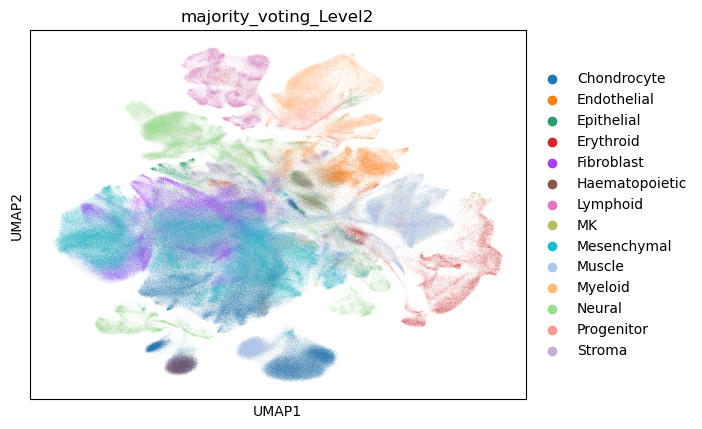

In [9]:
sc.pl.umap(adata, color="majority_voting_Level2")

In [ ]:
majority_voting_Level2

In [8]:
n_target = 300_000
n_obs    = adata.n_obs

if n_obs <= n_target:
    print(f"Only {n_obs} cells in total—no downsampling needed.")
    adata_sub = adata.copy()
else:
    # 3) Compute for each (Technology, Level2) group how many to sample
    obs = adata.obs[['Technology','majority_voting_Level2']]
    grp_sizes = obs.groupby(['Technology','majority_voting_Level2']).size()
    
    # proportional targets, rounded to integers
    targets = (grp_sizes / n_obs * n_target).round().astype(int)
    
    # correct any rounding‐drift so sum == n_target
    diff = n_target - targets.sum()
    if diff > 0:
        # add the extra draws to the largest groups
        for idx in targets.nlargest(diff).index:
            targets[idx] += 1
    elif diff < 0:
        # subtract from the largest groups
        for idx in targets.nlargest(-diff).index:
            targets[idx] -= 1
    
    # 4) Stratified sampling
    sampled_idx = (
        obs
        .groupby(['Technology','majority_voting_Level2'], group_keys=False)
        .apply(lambda df: df.sample(n=targets.loc[df.name], random_state=0))
        .index
    )
    
    # 5) Subset and copy
    adata_sub = adata[sampled_idx].copy()

/tmp/ipykernel_2850384/898536426.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_sizes = obs.groupby(['Technology','majority_voting_Level2']).size()
/tmp/ipykernel_2850384/898536426.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs
/tmp/ipykernel_2850384/898536426.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence thi

In [9]:
adata_sub

AnnData object with n_obs × n_vars = 300000 × 10000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'Sample_ID', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score', 'predicted_doublets', 'scrublet_cluster_score', 'bh_pval', 'predicted_doublets_p

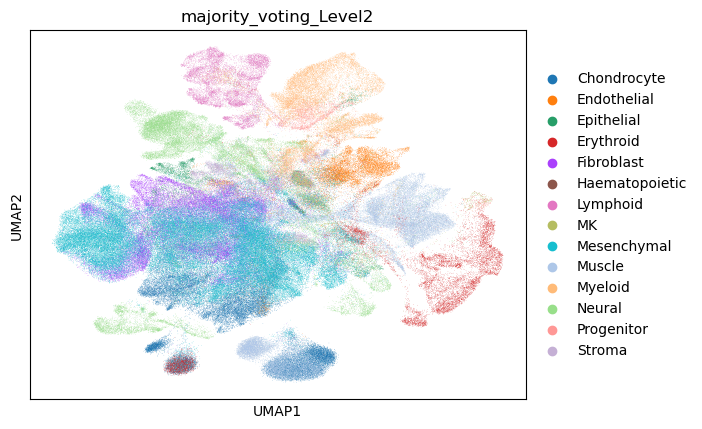

In [10]:
sc.pl.umap(adata_sub, color="majority_voting_Level2")

In [11]:
adata_sub.write_h5ad('/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_scvi_runs/scib_test_int.h5ad')

In [14]:
adata_unint= adata2[adata2.obs_names.isin(adata_sub.obs_names)].copy()

In [15]:
adata_unint.write_h5ad('/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_scvi_runs/scib_test_unintegrated.h5ad')

In [2]:
adata_pca= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_filtered_with_metadata_pca.h5ad') 

In [3]:
adata_unint_without_pca= sc.read_h5ad('/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_scvi_runs/scib_test_unintegrated.h5ad')

In [4]:
adata_unint_without_pca

AnnData object with n_obs × n_vars = 300000 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'Sample_ID', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score', 'predicted_doublets', 'scrublet_cluster_score', 'bh_pval', 'predicted_doublets_p

In [7]:
import pandas as pd
# 2) subset adata_a to cells in adata_b
cells_b = adata_unint_without_pca.obs["Cell_ID"].astype(str)
mask = adata_pca.obs["Cell_ID"].astype(str).isin(cells_b)
# if you care about peak memory, you can do in-place:
# adata_a._inplace_subset_obs(mask)
# otherwise:
adata_pca = adata_pca[mask]

# 3) grab the PCA array and matching Cell_IDs
X = adata_pca.obsm["X_pca"]                          # shape (n_cells, n_pcs)
cells = adata_pca.obs["Cell_ID"].astype(str).values  # exactly the subset order

# 4) build a DataFrame with Cell_ID index
pcs = [f"PC{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, index=cells, columns=pcs)
df.index.name = "Cell_ID"

# 5) write out to Parquet for fast, error-proof I/O
df.to_parquet(
    "/lustre/scratch126/cellgen/haniffa/sm54/BoneAtlasProject/data/bone_atlas_scvi_runs/scib_test_unintegrated_pca.parquet",
    engine="pyarrow",
    compression="snappy",
    index=True
)

In [72]:
import numpy as np

# assume:
#   adata_1.obs["Cell_ID"]  is a pandas Series of length ~1.5 M
#   pca_df_2               is your PCA DataFrame indexed by Cell_ID

# 1) pull out the cell IDs as strings
ids = adata_1.obs["Cell_ID"].astype(str)

# 2) get integer positions of each ID in the PCA index (C-loop)
pos = df222.index.get_indexer(ids)

# 3) check for any missing (-1 entries)
if (pos < 0).any():
    missing = np.where(pos < 0)[0]
    raise KeyError(f"PCA missing for {len(missing)} cells; first few at positions {missing[:5]}")

# 4) slice the underlying NumPy array very quickly
aligned_values = pca_df_2.values[pos, :]

# 5) assign in one go
adata_1.obsm["X_unintegrated_pca"] = aligned_values


NameError: name 'pca_df_2' is not defined

In [8]:
adata_pca

View of AnnData object with n_obs × n_vars = 300000 × 2500
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_p

/nfs/users/nfs_s/sm54/.local/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


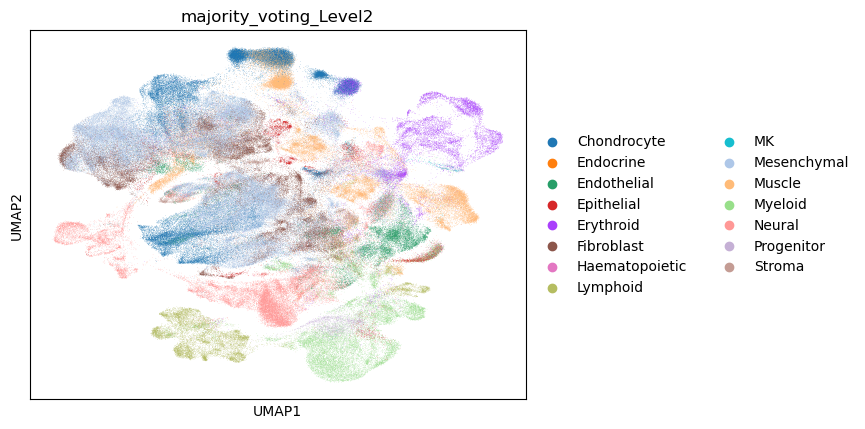

In [9]:
sc.pl.umap(adata_pca, color="majority_voting_Level2")

In [1]:
import scanpy as sc 

In [2]:
adata= sc.read_h5ad('/lustre/scratch127/cellgen/cellgeni/tickets/tic-4067/scvi_results/bone_atlas_filtered_with_metadata/all/adata_embedding.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 1391024 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'Sample_ID', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score', 'predicted_doublets', 'scrublet_cluster_score', 'bh_pval', 'predicted_doublets_

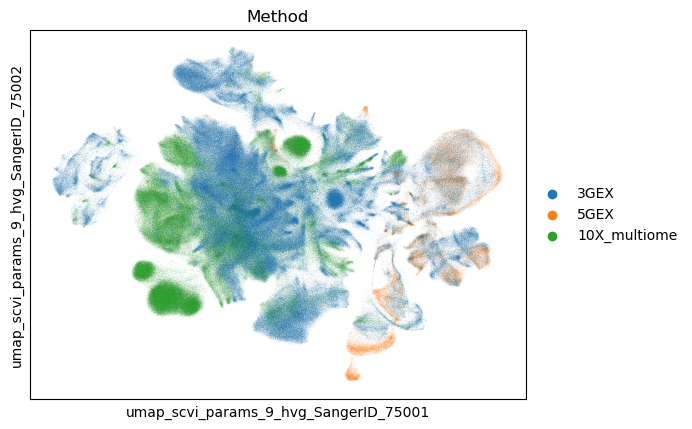

In [9]:
sc.pl.embedding(adata,basis='umap_scvi_params_9_hvg_SangerID_7500', color='Method')

In [5]:
adata.obsm['umap_scvi_params_9_hvg_SangerID_7500']

array([[ 8.969077 , -0.0500204],
       [ 6.9090023, 12.437393 ],
       [ 4.691218 ,  8.775255 ],
       ...,
       [-2.9090328, 15.443353 ],
       [-1.2354304, 11.699357 ],
       [-0.9386928, 11.78132  ]], dtype=float32)